# Het vinden van de elleboog van een grafiek

- Auteur: Jimmy Bierenbroodspot
- Datum: 21 juni 2024
- Locatie: Hogeschool Utrecht

## Inleiding

In dit document gaan we een algoritme implementeren voor het vinden van de 
elleboog van een kromme. Vervolgens gaan gaan we deze toepassen op het vinden
van de juiste aantal clustercentra en zullen we kijken hoe dit presteert
tegenover een dataset met CV's en het aantal kolommen.

In [1]:
import sys
sys.path.append("../")

from typing import Any
from pathlib import Path
import csv

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pypdf

from src.algorithm.clustering import ClusteringModel
import src.visualization as viz

plt.ion()

## De elleboog

Op deze pagina voor analytische functies in R staat
<sup>\[[1](#srcRopensci)\]</sup>:

> ... this function will find the "elbow" point. This is done by drawing an 
(imaginary) line between the first observation and the final observation. Then, 
the distance between that line and each observation is calculated. The "elbow" 
of the curve is the observation that maximizes this distance.

Als we dit om zouden zetten naar pseudocode zouden we het volgende kunnen doen:

1. Teken een lijn van de eerste observatie naar de laatste observatie.
2. Bereken de afstand tussen de observatie en de lijn.
3. Herhaal stap 3 voor elke observatie.
4. Neem de index van de hoogste waarde, dit is de optimale aantal clusters.

Laten we beginnen met een functie die de rechte lijn tekent. We gaan dit doen
door een punt op de y-as te zetten voor elke waarde die we op de x-as hebben.

In [2]:
def draw_straight_line[DataT: Any](
        x: npt.NDArray[DataT], 
        y: npt.NDArray[DataT],
) -> npt.NDArray[DataT]:
    delta_x = x[-1] - x[0]
    delta_y = y[-1] - y[0]
    gradient = delta_y / delta_x
    y_intercept = gradient * x[0] - y[0]

    return np.array([gradient * i - y_intercept for i in x])

Nu hebben we een functie die een y-coördinaat kan berekenen voor elke 
x-coördinaat. Als we de twee lijnen met dezelfde x-as tekenen krijgen we
het volgende:

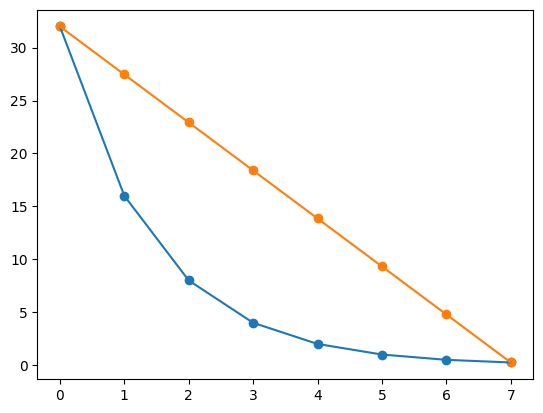

In [3]:
x_axis: npt.NDArray[np.float64] = np.arange(8, dtype=np.float64)

curve: npt.NDArray[np.float64] = np.array([32, 16, 8, 4, 2, 1, 0.5, 0.25])

subplot = viz.create_subplot()
viz.plot_graph(subplot.ax, x_axis, curve)
viz.plot_scatter(subplot.ax, x_axis, curve)

line: npt.NDArray[np.float64] = draw_straight_line(x_axis, curve)
viz.plot_graph(subplot.ax, x_axis, line)
viz.plot_scatter(subplot.ax, x_axis, line)

We kunnen deze functie nu gebruiken voor het vinden van de elleboog. We doen dit
door de absolute afstand tussen de y-waardes van de kromme en lijn voor elke 
x-waarde te berekenen. We hebben vervolgens alleen de index van de grootste
afstand nodig maar voor visualisatiedoeleinden geven we de lijst met alle
afstanden ook terug.

In [4]:
def find_elbow_of_curve[DataT: Any](x: npt.NDArray[DataT], y: npt.NDArray[DataT]) -> Any:
    line: npt.NDArray[DataT] = draw_straight_line(x, y)
    distances: npt.NDArray[np.float64] = np.zeros(len(x))

    for i in range(len(x)):
        distances[i] = np.abs(line[i] - y[i])

    return np.argmax(distances), distances

Als we nu een grafiek maken met de afstand tussen de twee lijnen op de y-as
kunnen we visualiseren waar de grootste afstand zit.

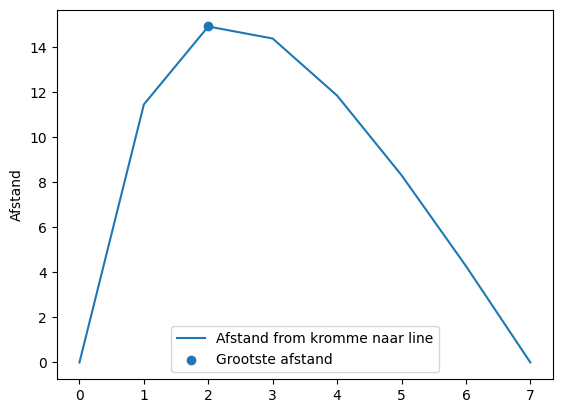

In [5]:
max_distance, distances = find_elbow_of_curve(x_axis, curve)

subplot = viz.create_subplot()
viz.plot_graph(subplot.ax, x_axis, distances)
viz.plot_scatter(subplot.ax, [max_distance], [distances[max_distance]])

subplot.ax.set_ylabel("Afstand")  # type: ignore
subplot.ax.legend(["Afstand from kromme naar line", "Grootste afstand"]);  # type: ignore

## Toepassen op echte data

Het wordt tijd dat we het model testen door samen met de elleboog-functie het
juiste aantal kolommen weten te vinden. We kiezen hiervoor een pdf-bestand uit
de dataset met CV's.

In [6]:
resume_number: int = 2
resume_path: Path = next(Path("../data/cv_pdf").glob(f"cv-{resume_number}-*.pdf")).resolve()
csv_path: Path = Path("../data/cv_cols.csv").resolve()

print("CV pdf:\t", resume_path)
print("CSV:\t", csv_path)

CV pdf:	 /home/jimmy/school/jaar-1/blok-d/ipass-23-24/data/cv_pdf/cv-2-16.pdf
CSV:	 /home/jimmy/school/jaar-1/blok-d/ipass-23-24/data/cv_cols.csv


Omdat dit een CV is met gevoelige informatie zullen we niet tonen wat hierin
staat. Wel kunnen we uit een dataset halen hoeveel kolommen dit bestand heeft.

In [7]:
num_cols: int

with csv_path.open("r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    num_cols = int(list(csv_reader)[resume_number][1])

print("Dit CSV bestand heeft", num_cols, "kolommen.")

Dit CSV bestand heeft 2 kolommen.


We zetten vervolgens de locatie van elke letter in een grafiek.

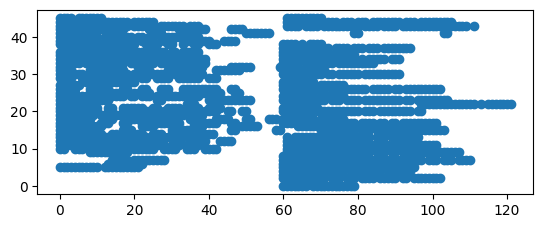

In [8]:
pdf_reader = pypdf.PdfReader(resume_path)
pdf_text = "\n".join([page.extract_text(extraction_mode="layout") for page in pdf_reader.pages])

character_position_list: list[tuple[int, int]] = []

for y, line in enumerate(pdf_text.splitlines()):
    for x, char in enumerate(line):
        if not char.isspace():
            character_position_list.append((x, y))

character_positions: npt.NDArray[np.int64] = np.array(character_position_list)

plt.scatter(x=character_positions[:,0], y=character_positions[:,1]) # type: ignore
plt.gca().set_aspect("equal", adjustable="box")

plt.show() # type: ignore

We voeren het model voor verschillende aantallen aan clusters uit. De score
gaat op de y-as en het aantal cluster op de x-as.

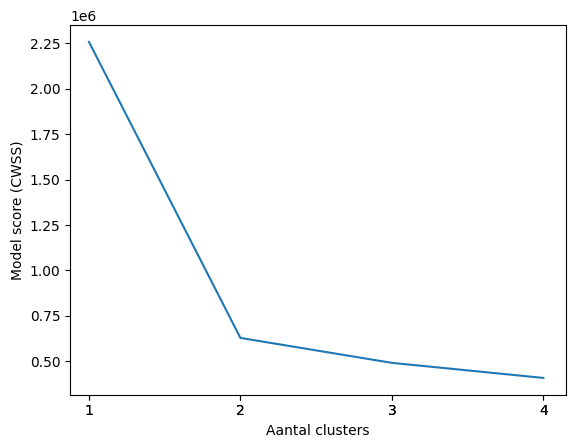

In [9]:
max_num_clusters: int = 5
n_clusters: npt.NDArray[np.int64] = np.arange(1, max_num_clusters)
model_scores: npt.NDArray[np.float64] = np.zeros(len(n_clusters))

for i, n in enumerate(n_clusters):
    model = ClusteringModel(character_positions, n, "lloyds")
    model.train(character_positions)
    model_scores[i] = model.error

plt.plot(n_clusters, model_scores)
plt.xticks([int(tick) for tick in plt.xticks()[0]])
plt.xlim(left=0.875)
plt.xlabel("Aantal clusters")
plt.ylabel("Model score (CWSS)")
plt.show()

Als we nu onze elleboogfunctie gebruiken op deze waardes kunnen we zien wat het
optimale aantal clusters is.

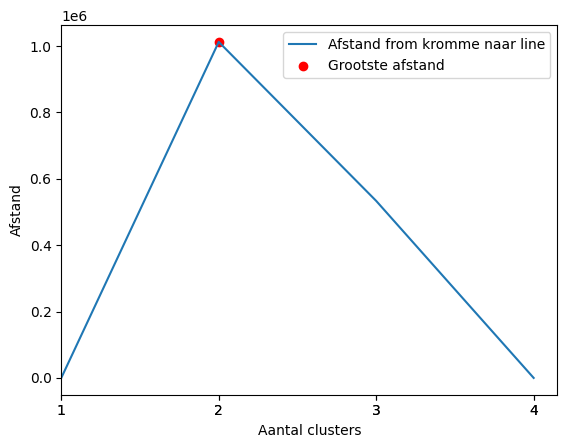

In [10]:
max_distance, distances = find_elbow_of_curve(n_clusters, model_scores)
plt.plot(n_clusters, distances)
plt.scatter(x=[n_clusters[max_distance]], y=[distances[max_distance]], color="red")
plt.ylabel("Afstand")
plt.xlabel("Aantal clusters")
plt.legend(["Afstand from kromme naar line", "Grootste afstand"])
plt.xticks([int(tick) for tick in plt.xticks()[0]])
plt.xlim(left=1)
plt.show()

## Conclusie

We hebben het algoritme nu getest op een enkele CV. Het resultaat hiervan is
correct maar we kunnen hier nog geen concrete conclusies uittrekken. Om dit wel
te kunnen doen zullen we eerst moeten kijken hoe deze methode presteert
tegenover alle bestanden in ons dataset.

## Vervolg

Naar aanleiding van de bevindingen in dit document zullen we de volgende acties
ondernemen:

- Concrete en herbruikbare functies schrijven voor het visualiseren van data.
- Concrete en herbruikbare functies schrijven voor de elleboogmethode.
- Concrete en herbruikbare functies schrijven voor het werken met de 
PDF-bestanden.
- Het model en elleboogfunctie testen tegenover de gehele dataset.

## Bronnen

<a id="srcRopensci"></a>[1] Find the “elbow” of a curve. (n.d.). Ropensci. Retrieved June 21, 2024, from https://docs.ropensci.org/pathviewr/reference/find_curve_elbow.html